<a href="https://colab.research.google.com/github/Loriane-07/PRA3024AnalysisofBigDatainPhysics/blob/main/Week4_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Some data-handling functions to download/import.

# from https://github.com/yandexdataschool/mlhep2018/blob/master/day2-Tue/seminar-03-keras-cnn/seminar_tf_keras.ipynb
"""I load some cifar"""

import numpy as np
from sklearn.model_selection import train_test_split
import os, sys
if sys.version_info[0] == 2:
    from urllib import urlretrieve
    import cPickle as pickle

else:
    from urllib.request import urlretrieve
    import pickle

def unpickle(file):
    fo = open(file, 'rb')
    if sys.version_info[0] == 2:
        dict = pickle.load(fo)
    else:
        dict = pickle.load(fo,encoding='latin1')
    
    fo.close()
    return dict




def download_cifar10(path,
                     url='https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
                     tarname='cifar-10-python.tar.gz',):
    import tarfile
    if not os.path.exists(path):
        os.mkdir(path)
    
        

    urlretrieve(url, os.path.join(path,tarname))
    tfile = tarfile.open(os.path.join(path,tarname))
    tfile.extractall(path=path)
    

def load_cifar10(data_path=".",channels_last=False,test_size=0.2,random_state=1337):
    
    test_path = os.path.join(data_path,"cifar-10-batches-py/test_batch")
    train_paths = [os.path.join(data_path,"cifar-10-batches-py/data_batch_%i"%i) for i in range(1,6)]
    
    if not os.path.exists(test_path) or not all(list(map(os.path.exists, train_paths))):
        print ("Dataset not found. Downloading...")
        download_cifar10(data_path)

    train_batches = list(map(unpickle,train_paths))
    test_batch = unpickle(test_path)

    X = np.concatenate([batch["data"] for batch in train_batches]).reshape([-1,3,32,32]).astype('float32')/255
    y = np.concatenate([batch["labels"] for batch in train_batches]).astype('int32')
    X_train,X_val,y_train,y_val = train_test_split(X,y,
                                                   test_size=test_size,
                                                   random_state=random_state)
    
    X_test = test_batch["data"].reshape([-1,3,32,32]).astype('float32')/255
    y_test = np.array(test_batch["labels"]).astype('int32')
    
    if channels_last:
        #convert from [batch,3,H,W] to [batch,H,W,3]
        #WARNING! Make this is only necessary for tensorflow-style dim order
        #If you use theano-style dimensions in keras config, skip this cell
        X_train = X_train.transpose([0,2,3,1])
        X_val   = X_val.transpose([0,2,3,1])
        X_test  = X_test.transpose([0,2,3,1])

    
    return X_train,y_train,X_val,y_val,X_test,y_test

In [2]:
import tensorflow as tf
#gpu_options = tf.GPUOptions(allow_growth=True, per_process_gpu_memory_fraction=0.1) # restricts GPU load for multi-user nodes

import keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)

2.4.1
2.4.3


In [3]:
# Load the data samples

x_train,y_train,x_val,y_val,x_test,y_test = load_cifar10("cifar_data",channels_last=True)

NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)
print("Val samples:", x_val.shape, y_val.shape)

Dataset not found. Downloading...
Train samples: (40000, 32, 32, 3) (40000,)
Test samples: (10000, 32, 32, 3) (10000,)
Val samples: (10000, 32, 32, 3) (10000,)


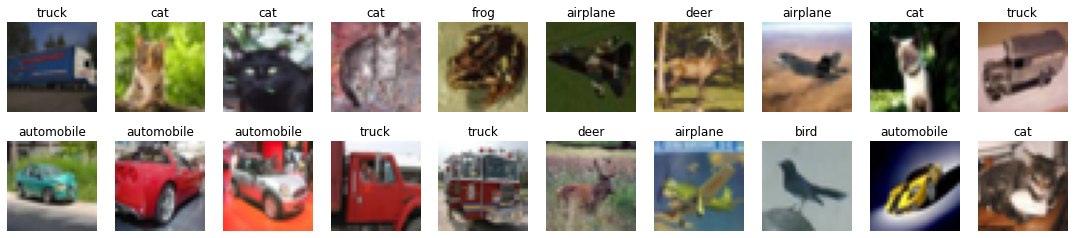

In [4]:
# show some random images from train, and their labels

cols = 10
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index]])
plt.show()

In [5]:
# normalize inputs
# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
# x_train = x_train.astype(np.float64) - 0.5

y_train = keras.utils.to_categorical(y_train, num_classes=10)

y_val = keras.utils.to_categorical(y_val, num_classes=10)

y_test = keras.utils.to_categorical(y_test, num_classes=10)

In [6]:
# import necessary building blocks
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

In [12]:
def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """

    model = Sequential()
    # First set of convolutional layers
    model.add(keras.layers.Conv2D(64, (3,3), strides=(1,1), padding='valid',activation='relu',input_shape=(32, 32, 3))) # convolutional network with 3x3 kernel 
    model.add(keras.layers.BatchNormalization())
    #model.add(keras.layers.MaxPool2D(pool_size=(2,2))) #Pooling 
    model.add(keras.layers.Conv2D(64, (3,3), strides=(1,1), padding='valid', activation='relu'))
    model.add(keras.layers.BatchNormalization())
    #model.add(keras.layers.MaxPool2D(pool_size=(2,2)))
    model.add(keras.layers.Conv2D(64, (3,3), strides=(1,1), padding='valid', activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPool2D(pool_size=(2,2)))
   
    # Second set of convolutional layers
    model.add(keras.layers.Conv2D(32, (3,3), strides=(1,1), padding='valid',activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Conv2D(32, (3,3), strides=(1,1), padding='valid',activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPool2D(pool_size=(2,2))) #Pooling 

    model.add(keras.layers.Flatten()) #Flattening the data
    model.add(keras.layers.Dense(1024, activation='relu')) #Dense layer
    model.add(keras.layers.Dropout(1/10)) #Dropout to prevent overfitting
    model.add(keras.layers.Dense(10, activation='softmax')) #output layer
    ### STUDENT CODE HERE ###
    ### --> Build your convolutional neural network. 
    ### First, make a CNN layer with some small kernels to learn some basic features, with Conv2D.
    ### Then, add a Pooling layer to pick up the relevant kernels.
    ### Then, Flatten it and add some fully-connected (Dense) normal NN layers,
    ###  to learn the relevant combinations of low-level kernel features.
    ### Finally, some regularisation is advised, using a Dropout layer, to avoid local minima.
    ### Make sure the output is of the same shape as the number of labels we have,
    ### And the input is the same as the figures (which now have a 3rd dimension - color!)
    ### Again, use google to find information on these classes.
    ### END STUDENT CODE ### 

    # Ensure normalized probabilities over the 10 classes
    model.add(Activation("softmax")) 
    model.summary()
    return model

make_model()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 30, 30, 64)        1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 64)        256       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 28, 28, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 26, 26, 64)        36928     
_________________________________________________________________
batch_normalization_3 (Batch (None, 26, 26, 64)        256       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 13, 13, 64)       

In [13]:
### STUDENT CODE HERE ###
### --> change the parameters below to perform a better training

INIT_LR =1e-3  # initial learning rate
BATCH_SIZE = 32
EPOCHS = 100


K.clear_session()  # clear default graph
# don't call K.set_learning_phase() !!! (otherwise will enable dropout in train/test simultaneously)
model = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=keras.optimizers.Adamax(lr=INIT_LR),  # for SGD.
    metrics=['accuracy']  # report accuracy during training
)

# fit model
model.fit(
    x_train, y_train,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    shuffle=True,
)

# save weights to file to avoid re-training
model.save_weights("weights.h5")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 26, 26, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0

In [14]:
# load weights from file (can call without model.fit)
model.load_weights("weights.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


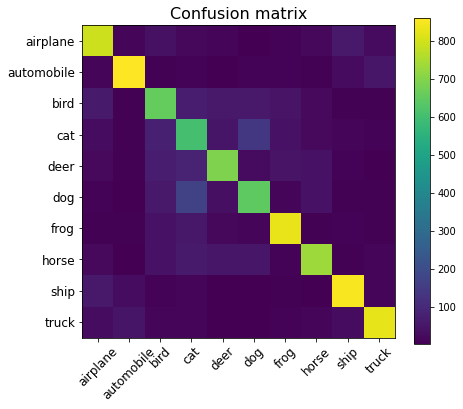

Test accuracy: 0.7516


In [15]:
# make test predictions
y_pred_test = model.predict_proba(x_test)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)
y_test_index = [list(onehot).index(1) for onehot in y_test]

# confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(y_test_index, y_pred_test_classes))
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(y_test_index, y_pred_test_classes))

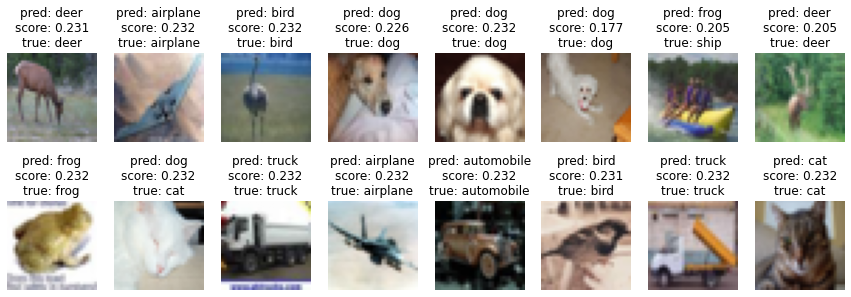

In [26]:
# inspect preditions
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label = cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[y_test_index[random_index]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()

# Report

## The model

**Choice of parameters and initial model**

To tune the parameters, the following model was used: three convolutional layers each followed by a pooling layer instead of a batch normalization layer and one dense layer. Each convolutional layers had a filter with dimension 64. This specific size was chosen because commonly, numbers that are powers of two are chosen. The model was also trained with filter having size 16 and 32, however, it did not exhibit an accuracy as high as when 64 is chosen (comparison with the same number of layers, kernel size, pooling size, epochs of training, learning rate and batch size). The kernel size was chosen to be 3x3 for all layers. Trials were made using higher or lower kernel sizes but it led to issues in the third layer since the input was smaller than the kernel size. 

Then, decreasing the size of the kernel within layer was also tried (first layer: 6x6; second layer: 4x4; third layer: 2x2). This yielded testing accuracy between 58 and 63% depending on the epoch size (80 or 120) and the number of neurons in the dense layer (128, 256, 512, 1024). Despite increasing the number of neurons in the dense layer, the maximum test accuracy reached was below 65% and the stabilization occured at about 100 epochs and hence, having different kernel sizes was abandonned.

When a fourth convolutional layer and its pooling layer were added, it decreased the performances of the model. First, the fourth layer had to have a kernel of dimensions 2x2 and a pooling of dimension 1x1. Otherwise, an error due to negative dimension size was displayed (see bottom of the section). In this format, the model reached a maximul accuracy of about 68%. The model was trained over 150 epochs and the stabilization occured at about 70 epochs (different learning rate were used: 1*10^-3, 5*10^-3, 10e^-3).

Different activation functions were tried: sigmoid, relu and tanh. Sigmoid was found to be detrimental to learning with a model composed of either 3 or 4 convolutional layers. The combination, Relu (1st layer), sigmoid (2nd layer) and relu (3rd layer), relu (dense layer), even prevented the model to learn as after 10 epochs, the accuracy of the training did not change and was of 0.0918%. Other configurations using a combination of sigmoid and relu displayed resulted in an accuracy of about 63%. Tanh was not found to have any influence on the accuracy in comparison to relu. Hence, for convenience, relu was used in every layer except the output layer.

The number of neurons in the dense layer was also varied: 128, 256, 512, 1024. It was found that 128 and 256 was too small to yield the expected results. Running the model with 100 epochs, 1*10^-3 learning rate yield an accuracy of 0.7072 with 512 neurons and 0.71 with 1024 neurons. A dense layer with 1024 neurons was kept.

When the model described was trained over 150 epochs, it did not increase its accuracy (reached a maximum value of about 72%). This is why it was deemed sufficient to train the model with 100 epochs (even though stabilization could already be observed around 70 epochs). The most optimal learning rate was found to be 1*10^-3, even though it only caused slight changes in the final accuracy rate.

**The Final Model**

 Once the optimal parameters were defined, an accuracy of 71% was reached. Hence, in order to improve the efficiency of the model it was tried to add convolutional layers with smaller filters. This allowed to improve the accuracy to 75.16%. A few changes had to be made. First a batch normalization layer was added after each convolutional layer. Then, the pooling was only performed at the end of the first set of convolutionnal layers and at the end of the scond set. This allowed to prevent dimension errors. Reducing the size of the filters for the second set of convolutional layers also allowed to prevent dimension errors. As can be seen in the training, the model could have been trained with about 50 epochs and similar results would have been gathered. However, over the weekend, I got a GPU error from google colab saying that I used too much GPU and I was hence disconnected and not allowed to use googgle colaboratory for about a day. In order to ensure that I would have results to show before the deadline, I decided not to run the model again.


**The iteration path**

The filter is the trainable parameter of the convolutional layer and is a 3D structure composed of kernels (2D structures in the model implemented). The kernels are also trainable and their weights will be adjusted throughout the training session. In this model kernels all have sizes 3x3 this means that they will go in the picture many times. For example, in this case, the kernel will go on a picture with dimension 32x32 (ignoring the colour dimension for the purpose of the example), if we start at the upper left corner, the kernel will first cover the three first pixels in each dimension. Then, it will move one pixel towards the right (strides set to 1), covering pixels 2 to 4 included and so on until it has covered the whole picture.

The padding parameter is used to add a row and a column of pixels around the picture. This is done such that every pixel of the picture will be at some point in the middle line of the kernel. The activation function defines the function that will be applied to the input data. Here the relu function was selected. This function gets rid of all the negative values by setting those to 0. In opposition to other functions such as tanh and sigmoid the relu function does not have an upper limit since the positive numbers stay unchanged. On the other hand, tanh puts all the values in a range of -1 to 1 while sigmoid reassigns values from 0 to 1 to each pixel of the kernel.

The pooling layer is aimed at reducing the number of dimensions of the output filters of a convolutional layer. Here, the max pooling is chosen. This means that for all the filters produced, the pooling will select the maximum value of a 2x2 array and compute it in a new array which will be the input to the next layer. Hence a 2x2 array becomes a 1x1 array in this case.

Batch normalization is aimed at reducing the number of epochs required to train the model as it will ensure that the distribution of the data is kept similar over the training.

Once the data has been trough all the convolutional layers, it is flattened (reduced to a one dimensional array) which allows the connection with the dense layer. The dense layer is composed of 10 neurons since there are 10 categories to which the picture could belong. The dropout layer between the flattening layer and the dense layer is used to prevent overfitiing of the model.

**Dimension error:**

 Negative dimension size caused by subtracting 2 from 1 for '{{node max_pooling2d_17/MaxPool}} = MaxPool[T=DT_FLOAT, data_format="NHWC", explicit_paddings=[], ksize=[1, 2, 2, 1], padding="VALID", strides=[1, 2, 2, 1]](Placeholder)' with input shapes: [?,1,1,64].

## Results

As can be seen below the confusion matrix, the model produced has an accuracy of 75.16%. The confusion matrix shows that the model predicts best (above 80% accuracy) for the automobile, frog, truck and ship categories. On the other hand, dogs and cats are the least well predicted categories by the model. It can be noticed that cats are often mistaken for dogs and the other way around. The bird category also displays interesting patterns. In fact, birds are likely to be mistaken with all the other categories besides the best predicted ones by the model (automobile, frog, ship and truck).

Another interesting feature is that the model seems better at predicting human made objects than animals. In fact, the following categories: airplane, automobile, ship and truck can all be predicted with an accuracy of at least 78%. On the other hand, the animal categories (bird, cat, deer, dog and horse) all have a prediction accuracy comprised between 60% (cats) to 72% (horse). Only frogs are animals which are part of the best predicted categories.

# Conclusion

The best parameters were found mainly by trial and errors to have a first convolutional network that achieved an acuracy above 70%. Then, a second set of convolutional layers with a smaller dimension was added to see if the accuracy could be improved. By adding batch normalization layers instead of pooling layers, the accuracy of the model containing two sets of convolutional layers was significantly increased. The final accuracy is 75.16%.

One point that could be improved is the probability of the prediction. In fact, for an unknown reason no matter how much the accuracy improved, this prediction was never above 0.232. Even if the model had an accuracy of 58%, a prediction of 0.232 could be achieved which is the same as now display for a model with an accuracy of 75.16%.

# Some tips on how to improve:

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.

## Potential grading:
* starting at zero points
* +2 for describing your iteration path in a report below.
* +2 for building a network that gets above 20% accuracy
* +1 for beating each of these milestones on __TEST__ dataset:
    * 50% (5 total)
    * 60% (6 total)
    * 65% (7 total)
    * 70% (8 total)
    * 75% (9 total)
    * 80% (10 total)

## Bonus points
Common ways to get bonus points are:
* Get higher score, obviously.
* Anything special about your NN. For example \"A super-small/fast NN that gets 80%\" gets a bonus.
* Any detailed analysis of the results. (saliency maps, whatever)


## Tips on what can be done:

 * __Network size__
   * More neurons, 
   * More layers, ([lasagne docs](http://lasagne.readthedocs.org))
   * Nonlinearities in the hidden layers
   * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

 * __Convolution layers__
   * they __are a must__ unless you have any super-ideas
   * `network = lasagne.layers.Conv2DLayer(prev_layer,`
     `                       num_filters = n_neurons,`
     `                       filter_size = (filter width, filter height),`
     `                       nonlinearity = some_nonlinearity)`
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment to try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.

   * Plenty other layers and architectures
     * http://lasagne.readthedocs.org/en/latest/modules/layers.html
     * batch normalization, pooling, etc


 * __Early Stopping__
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum


 * __Faster optimization__ - 
   * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (lasagne.layers.batch_norm) FTW!


 * __Regularize__ to prevent overfitting
   * Add some L2 weight norm to the loss function, theano will do the rest
     * Can be done manually or via - http://lasagne.readthedocs.org/en/latest/modules/regularization.html
   * Dropout - to prevent overfitting
     * `lasagne.layers.DropoutLayer(prev_layer, p=probability_to_zero_out)`   
     * Don't overdo it. Check if it actually makes your network better


 * __Data augmentation__ - getting 5x as large dataset for free is a great deal
   * Zoom-in+slice = move
   * Rotate+zoom(to remove black stripes)
   * any other perturbations
   * Add Noize (easiest: GaussianNoizeLayer)
   * Simple way to do that (if you have PIL/Image): 
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.


